### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random
import plotly.express as px

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

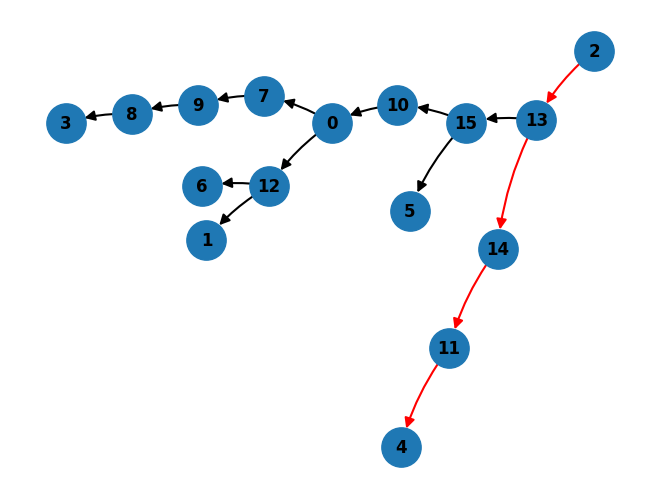

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [4]:
model_name="model.pt"

In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%


KeyboardInterrupt: 

In [ ]:
test_graph = generate_example(n_states, 5, order="random")
labels, test_cache = get_example_cache(test_graph, model, dataset)


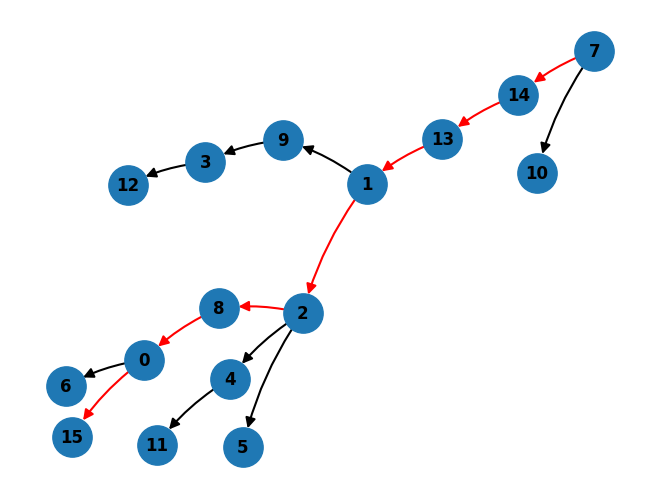

In [ ]:
parse_example(test_graph)

In [ ]:
labels, cache = get_example_cache(test_graph, model, dataset)

In [ ]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: understanding embeddings mlp

In [ ]:
mlp_activations = cache["blocks.5.mlp.hook_post"][0][47:60].cpu().detach()
mlp_activations = mlp_activations - mlp_activations.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(mlp_activations, axis=1, keepdims=True)
mlp_activations = mlp_activations / row_norms


In [ ]:
labels[47:60]

['7', '>14', '>13', '>1', '>2', '>8', '>0', '>15', ',', ',', ',', ',', ',']

In [ ]:
imshow(cache["blocks.5.mlp.hook_post"][0][47:60])

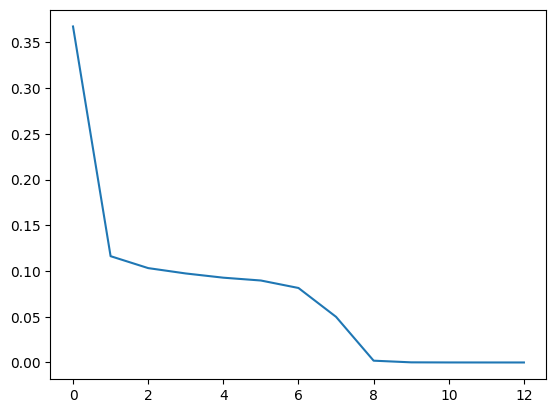

In [ ]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(mlp_activations)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [ ]:
cache[f"blocks.{5}.mlp.hook_post"][0][47:60].shape

torch.Size([13, 512])

In [ ]:
cache[f"blocks.{1}.attn.hook_v"].shape

torch.Size([1, 65, 1, 128])

In [ ]:
cache[f"blocks.{5}.mlp.hook_post"].shape

torch.Size([1, 65, 512])

In [ ]:
cache[f"blocks.{1}.attn.hook_v"].shape

torch.Size([1, 65, 1, 128])

In [ ]:
model.reset_hooks()

In [ ]:
for layer in range(model.cfg.n_layers):
    X = []
    for i in range(1_000):
            # Sample example
            test_graph = generate_example(n_states, i, order="random")
            pred, correct = eval_model(model, dataset, test_graph)
            if not correct:
                continue
            labels, cache = get_example_cache(pred, model, dataset)
            # Record information
            X.append(cache[f"blocks.{layer}.mlp.hook_post"][0][47:63])
    X = torch.cat(X, dim=0).detach().cpu().numpy()
    pca = PCA(n_components=64)  #n_components=k k is the desired rank of the approximation
    pca = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"layer{layer}")
    plt.plot(explained_variance)

    plt.show()
        

layer0


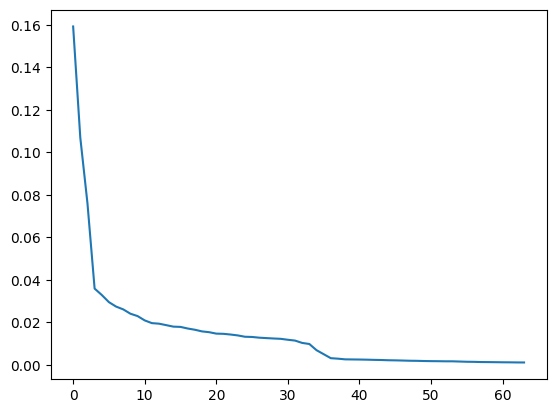

layer1


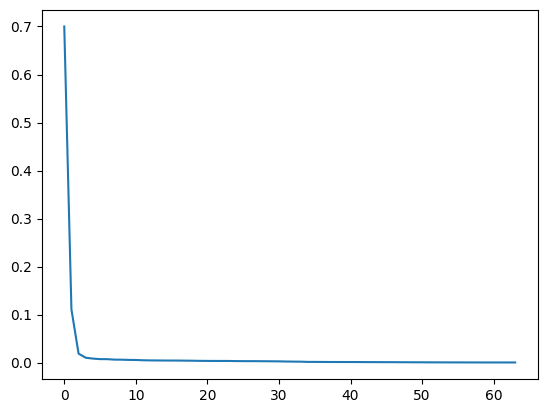

layer2


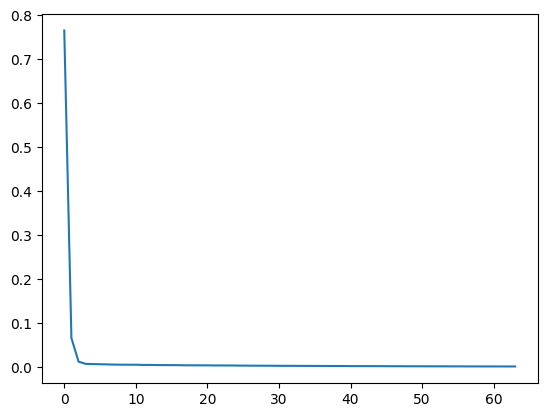

layer3


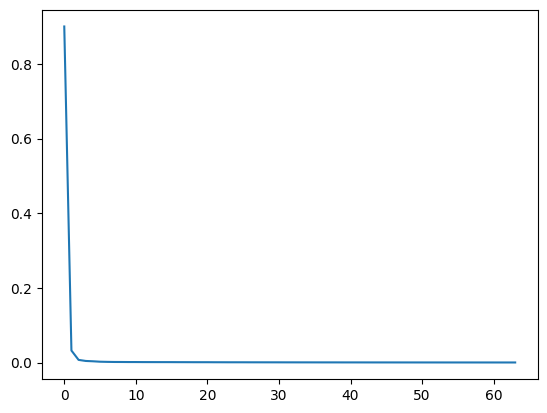

layer4


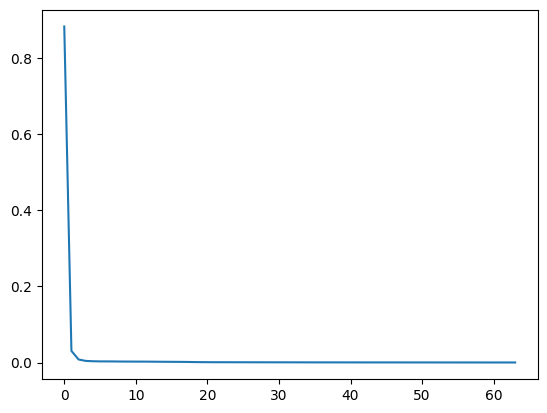

layer5


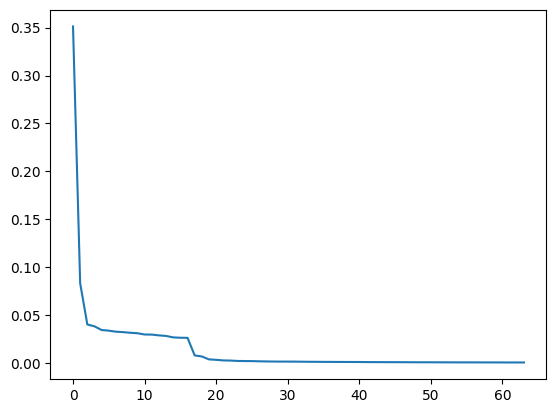

In [ ]:
for layer in range(model.cfg.n_layers):
    X = []
    for i in range(1_000):
            # Sample example
            test_graph = generate_example(n_states, i, order="random")
            pred, correct = eval_model(model, dataset, test_graph)
            if not correct:
                continue
            labels, cache = get_example_cache(pred, model, dataset)
            # Record information
            X.append(cache[f"blocks.{layer}.mlp.hook_post"][0][47:64])
    X = torch.cat(X, dim=0).detach().cpu().numpy()
    pca = PCA(n_components=64)  #n_components=k k is the desired rank of the approximation
    pca = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"layer{layer}")
    plt.plot(explained_variance)

    plt.show()
        

layer0


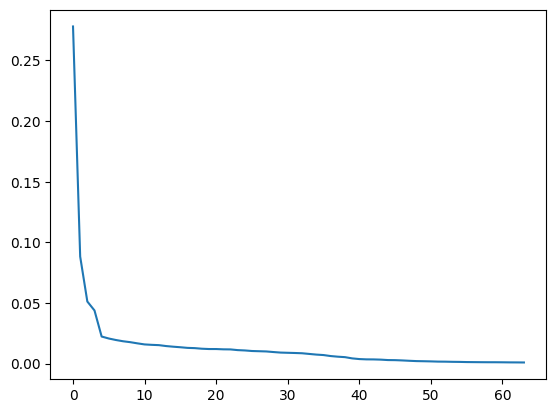

layer1


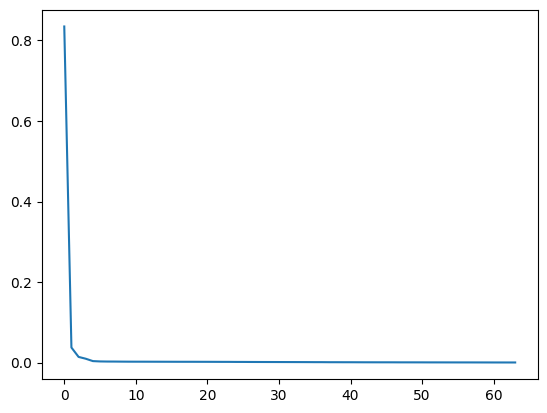

layer2


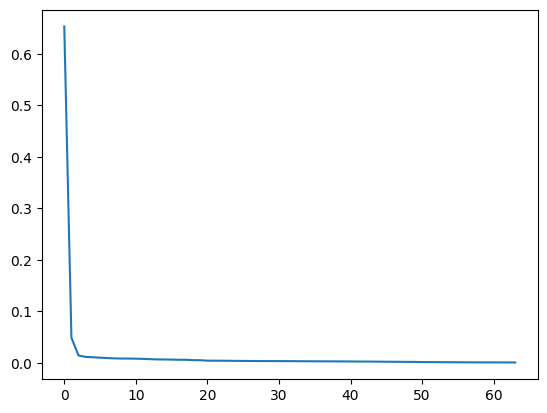

layer3


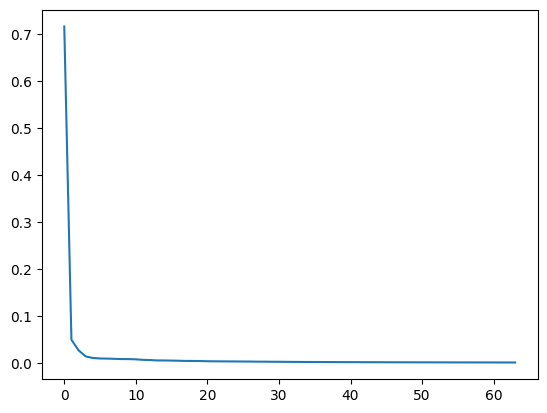

layer4


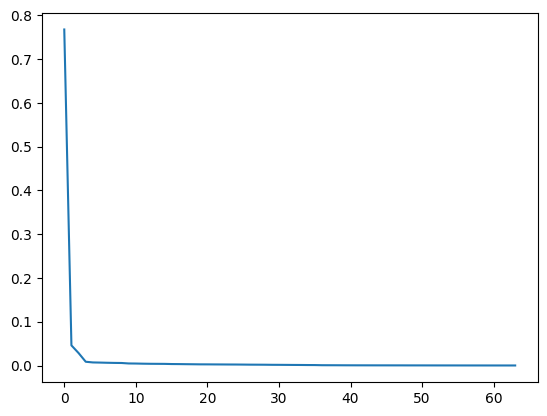

layer5


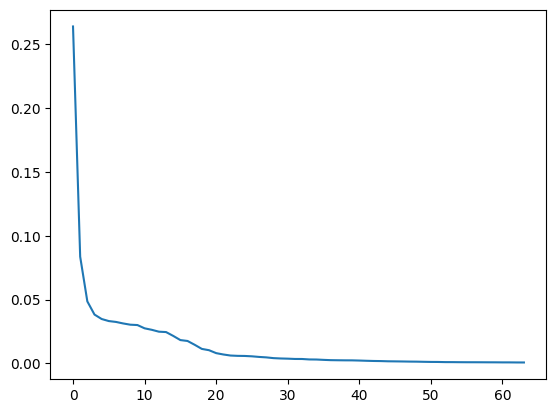

In [ ]:
for layer in range(model.cfg.n_layers):
    X = []
    for i in range(1_000):
            # Sample example
            test_graph = generate_example(n_states, i, order="random")
            pred, correct = eval_model(model, dataset, test_graph)
            if not correct:
                continue
            labels, cache = get_example_cache(pred, model, dataset)
            # Record information
            X.append(cache[f"blocks.{layer}.mlp.hook_post"][0])
    X = torch.cat(X, dim=0).detach().cpu().numpy()
    pca = PCA(n_components=64)  #n_components=k k is the desired rank of the approximation
    pca = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"layer{layer}")
    plt.plot(explained_variance)

    plt.show()
        

layer0


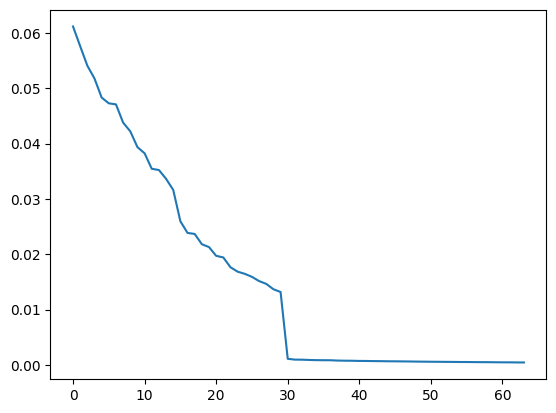

layer1


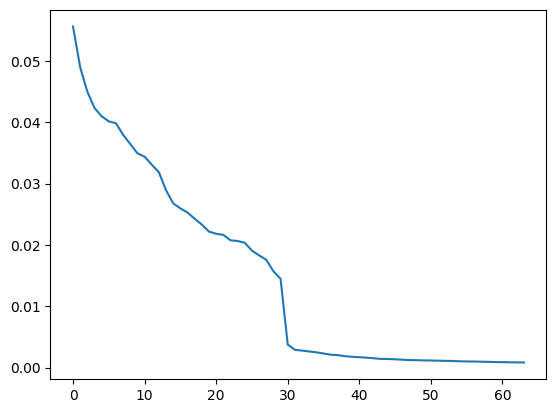

layer2


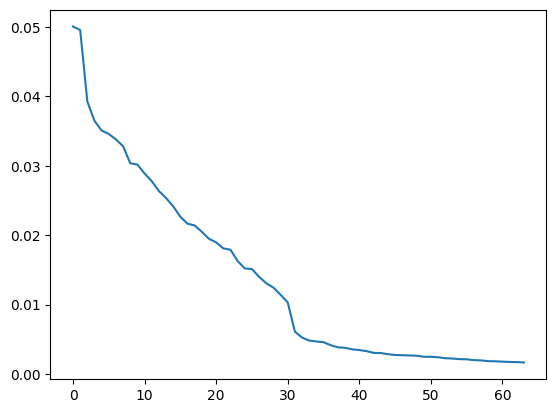

layer3


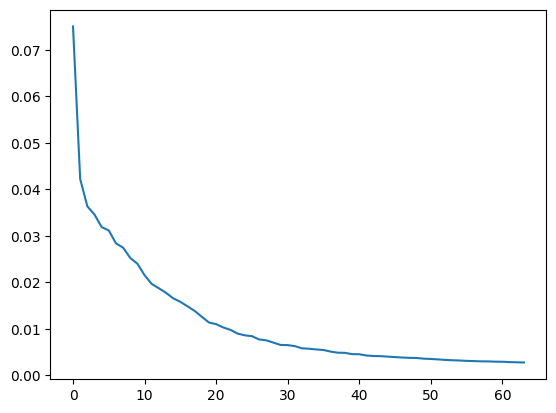

layer4


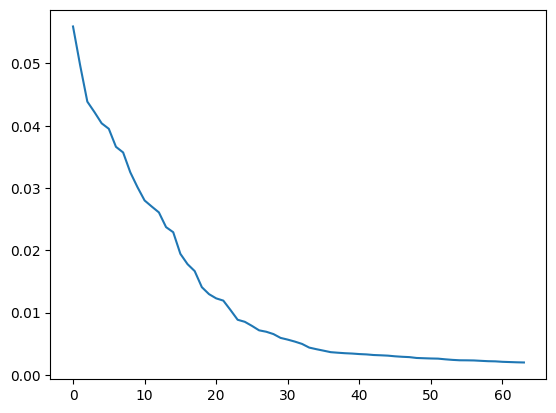

layer5


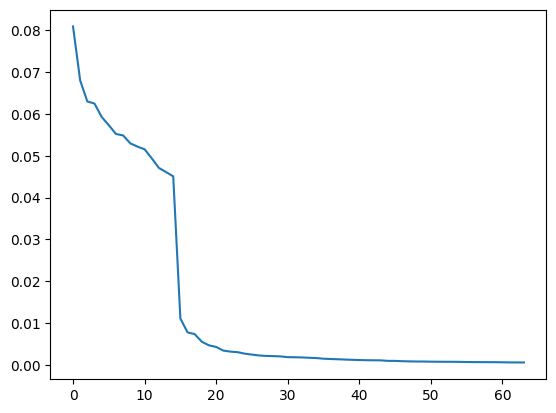

In [ ]:
for layer in range(model.cfg.n_layers):
    X = []
    for i in range(1_000):
            # Sample example
            test_graph = generate_example(n_states, i, order="random")
            pred, correct = eval_model(model, dataset, test_graph)
            if not correct:
                continue
            labels, cache = get_example_cache(pred, model, dataset)
            # Record information
            X.append(cache[f"blocks.{layer}.mlp.hook_post"][0][47:48])
    X = torch.cat(X, dim=0).detach().cpu().numpy()
    pca = PCA(n_components=64)  #n_components=k k is the desired rank of the approximation
    pca = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"layer{layer}")
    plt.plot(explained_variance)

    plt.show()
        

In [ ]:
cache[f"blocks.{layer}.mlp.hook_post"][0][47:48].shape

torch.Size([1, 512])

In [ ]:
model.reset_hooks()

layer0


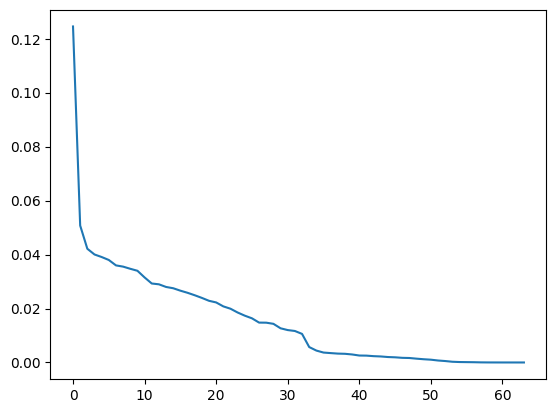

layer1


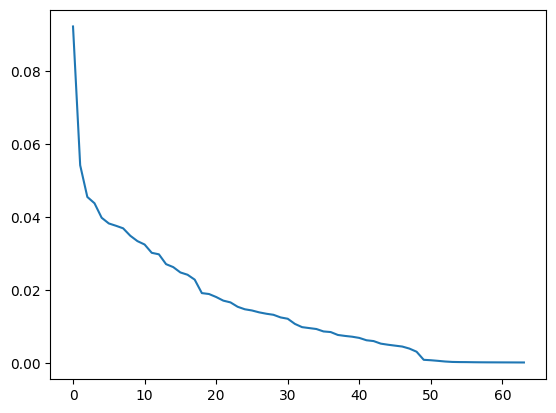

layer2


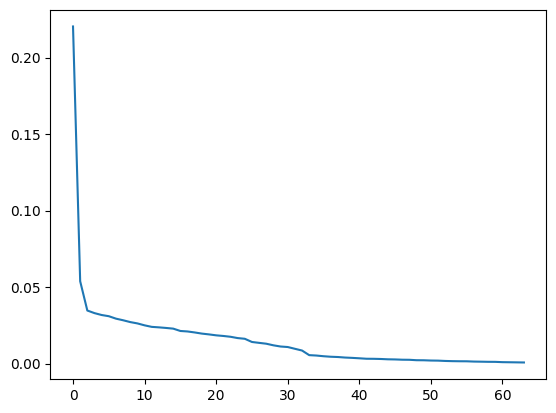

layer3


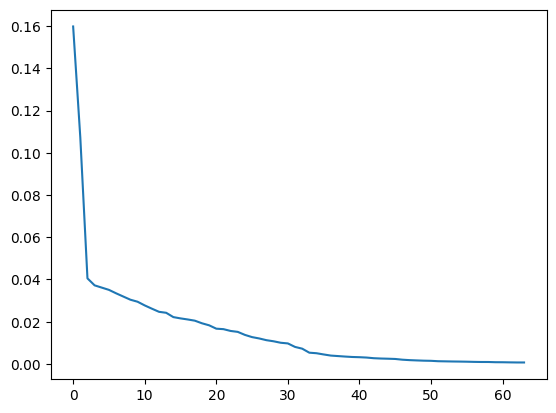

layer4


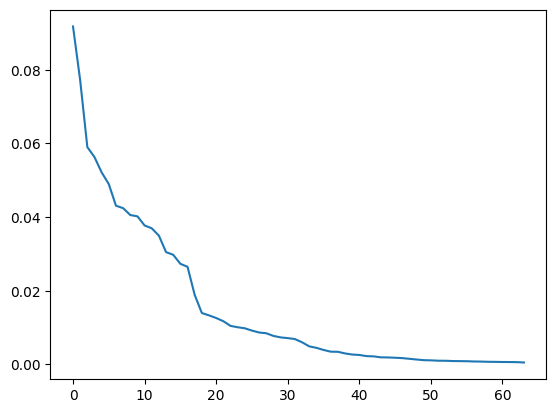

layer5


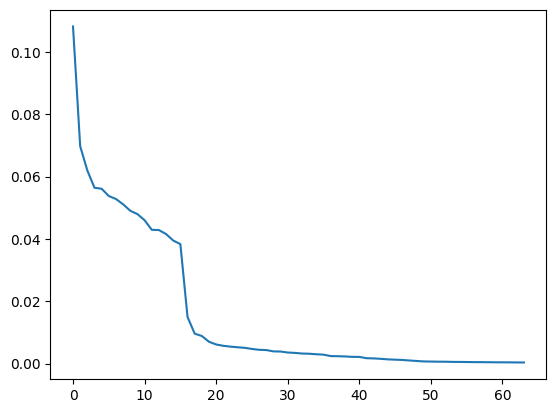

In [ ]:
for layer in range(model.cfg.n_layers):
    X = []
    for i in range(1_000):
            # Sample example
            test_graph = generate_example(n_states, i, order="random")
            pred, correct = eval_model(model, dataset, test_graph)
            if not correct:
                continue
            labels, cache = get_example_cache(pred, model, dataset)
            # Record information
            tokens = dataset.tokenize(test_graph)[:-1]
            labels = [dataset.idx2tokens[idx] for idx in tokens]
            end_idx = num_last(labels, ",") 
            X.append(cache[f"blocks.{layer}.mlp.hook_pre"][0][47:end_idx])
    X = torch.cat(X, dim=0).detach().cpu().numpy()
    pca = PCA(n_components=64)  #n_components=k k is the desired rank of the approximation
    pca = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"layer{layer}")
    plt.plot(explained_variance)

    plt.show()

layer0


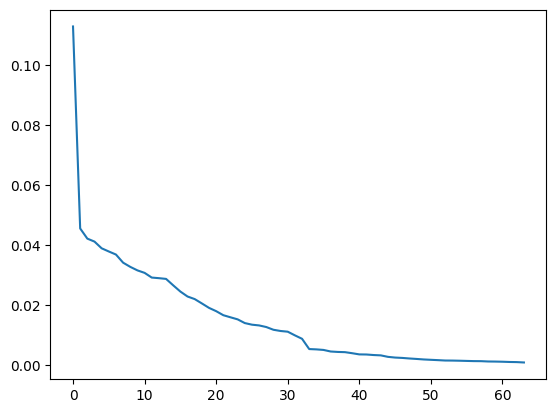

layer1


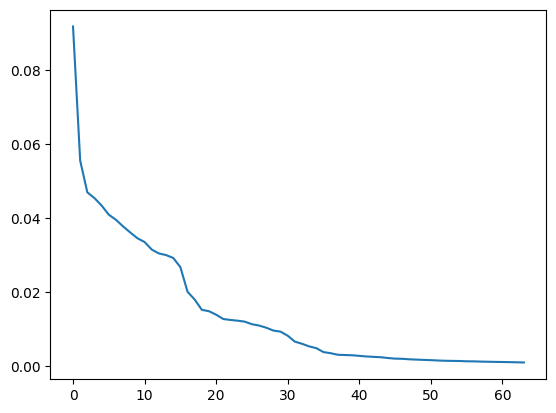

layer2


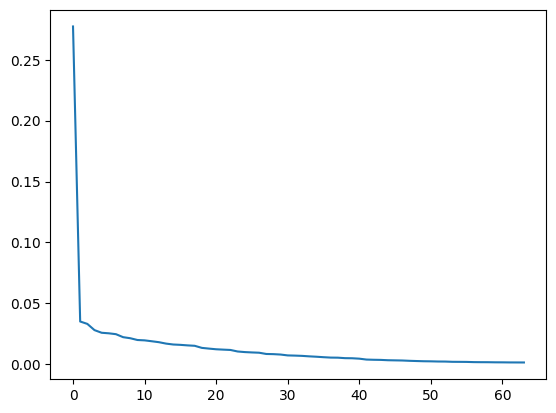

layer3


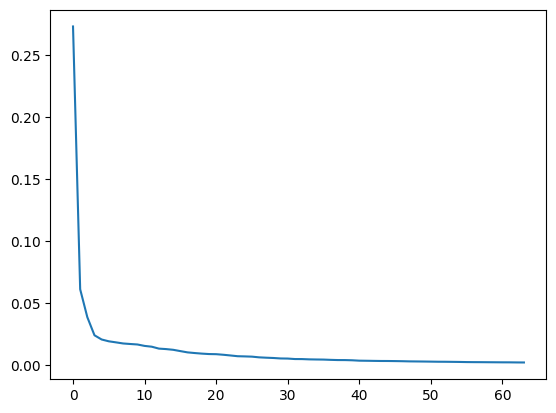

layer4


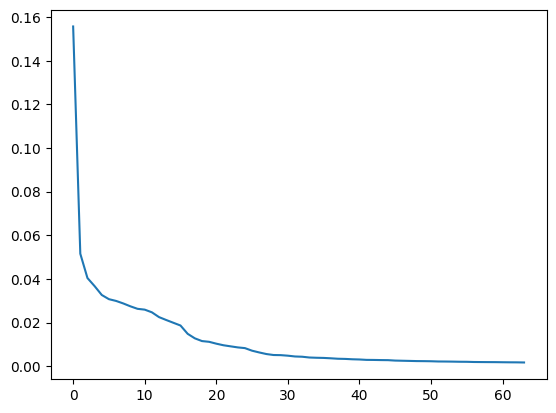

layer5


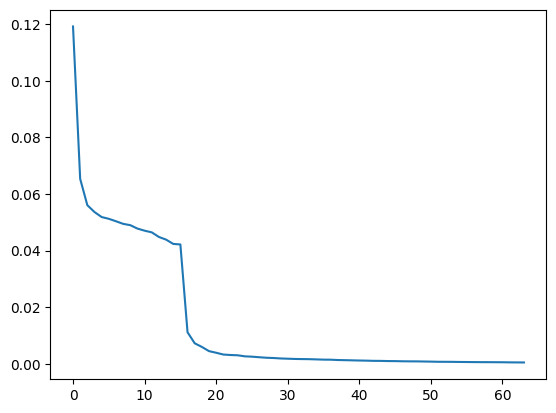

In [ ]:
for layer in range(model.cfg.n_layers):
    X = []
    for i in range(1_000):
            # Sample example
            test_graph = generate_example(n_states, i, order="random")
            pred, correct = eval_model(model, dataset, test_graph)
            if not correct:
                continue
            labels, cache = get_example_cache(pred, model, dataset)
            # Record information
            tokens = dataset.tokenize(test_graph)[:-1]
            labels = [dataset.idx2tokens[idx] for idx in tokens]
            end_idx = num_last(labels, ",") 
            X.append(cache[f"blocks.{layer}.mlp.hook_post"][0][47:end_idx])
    X = torch.cat(X, dim=0).detach().cpu().numpy()
    pca = PCA(n_components=64)  #n_components=k k is the desired rank of the approximation
    pca = pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    print(f"layer{layer}")
    plt.plot(explained_variance)

    plt.show()
        

In [ ]:
cache[f"blocks.{5}.mlp.hook_post"][0][47:60].shape

torch.Size([13, 512])

In [ ]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [ ]:
def add_low_rank_hook(layer, k,samples=1_000):
    
    X = []

    for i in range(samples):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{layer}.mlp.hook_post"][0][47:64])

    X = torch.cat(X, dim=0).detach().cpu().numpy()

    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X)

    # Add low-rank hook

    from functools import partial

    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[0][ position, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[0, position, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre


    temp_hook_fn = partial(low_rank_hook, position= [range(47,63)])
    model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)

In [ ]:
def add_low_rank_hook_modified(layer, k,samples=1_000):
    
    X = []

    for i in range(samples):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        tokens = dataset.tokenize(test_graph)[:-1]
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") 
        X.append(cache[f"blocks.{layer}.mlp.hook_pre"][0][47:end_idx])

    X = torch.cat(X, dim=0).detach().cpu().numpy()

    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X)

    # Add low-rank hook

    from functools import partial

    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[0][ position, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[0, position, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre


    temp_hook_fn = partial(low_rank_hook, position= [range(47,63)])
    model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)

In [ ]:
model.reset_hooks()
#add_low_rank_hook(1, 36,samples=1000)
#add_low_rank_hook(2, 36,samples=1000)
#add_low_rank_hook(3, 3,samples=1000)
add_low_rank_hook_modified(4, 32,samples=1000)
#add_low_rank_hook_modified(5, 16,samples=1000)

In [ ]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1
      #else:  
        #parse_example(graph)
        #plt.show()
        #print(pred)

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 90.0000%
random: 99.0000%


In [ ]:
X = []

for i in range(1_000):
        # Sample example
        test_graph = generate_example(n_states, i, order="random")
        pred, correct = eval_model(model, dataset, test_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(pred, model, dataset)
        # Record information
        X.append(cache[f"blocks.{layer}.mlp.hook_post"][0][48:60])

X = torch.cat(X, dim=0).detach().cpu().numpy()


In [ ]:
pca_128 = PCA(n_components=128)  # k is the desired rank of the approximation
pca_128 = pca.fit(X)

In [ ]:
pca_16 = PCA(n_components=16)  # k is the desired rank of the approximation
pca_16 = pca.fit(X)

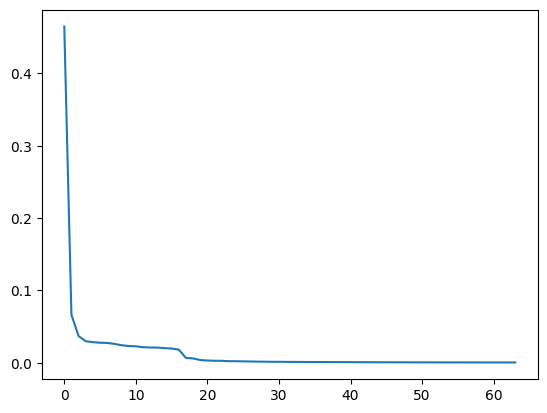

In [ ]:
explained_variance = pca_16.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [ ]:
pca_16.n_components_

64

In [ ]:
imshow(pca_128.components_[0:16])

In [ ]:
test_graph = generate_example(n_states, i, order="random")

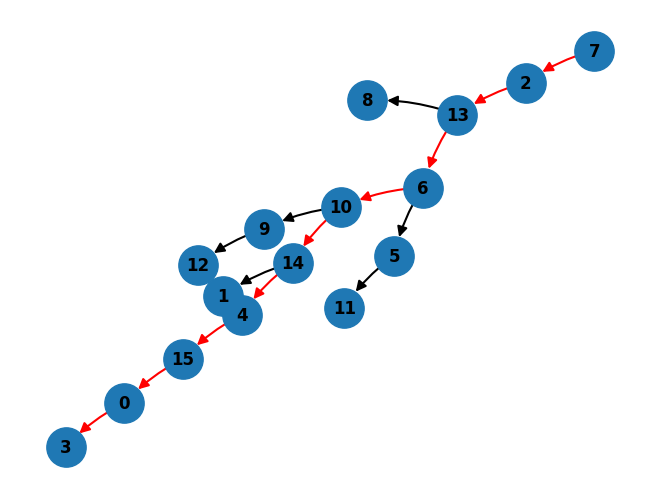

In [ ]:
parse_example(test_graph)

In [ ]:
def ablation_hook(
            resid_pre,
            hook):
        # Each HookPoint has a name attribute giving the name of the hook.
        resid_pre = resid_pre*0
        return resid_pre

In [ ]:
labels, test_cache = get_example_cache(pred, model, dataset)

In [ ]:
test_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [ ]:
def logit_lens_hook(pred, model,dataset, lenses=None):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.argmax(-1)
        lens_out = [dataset.idx2tokens[i] for i in out_proj]
        outs.append([f"Layer {layer} LL"] + lens_out[47:end])
    # Plot data
    header = dict(values=["Current Input"] + labels[47:end])
    rows = dict(values=np.array(outs).T.tolist())
    table = go.Table(header=header, cells=rows)
    layout = go.Layout(width=1000, height=700)
    figure = go.Figure(data=[table], layout=layout)
    figure.show()

In [ ]:
def logit_lens_correct_probs_hook(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
            out_proj = out_proj.softmax(-1)
        probs.append( out_proj[position, correct_token_idx].item() )
    # Plot data
    return probs, correct_token ,labels

In [ ]:
test_graph = generate_example(n_states, 5, order="backward")

In [ ]:
test_graph

'7>10,7>14,14>13,13>1,1>9,1>2,9>3,2>4,2>5,2>8,3>12,4>11,8>0,0>15,0>6|6:7>14>13>1>2>8>0>6'

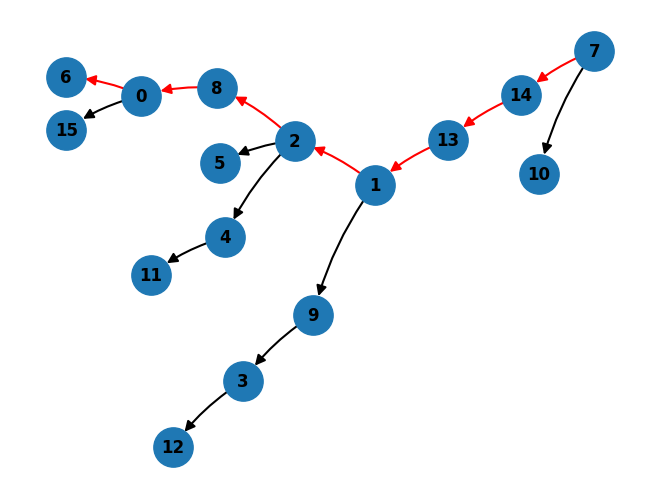

In [ ]:
parse_example(test_graph)

In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)

In [ ]:
logit_lens_hook(test_graph,model,dataset, lenses=None)

In [ ]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [ ]:
lenses = calculate_tuned_lens(model, dataset)

0.5739954251847383
0.5916437970282564
0.6267808003854033
0.7397780656965883
0.8472505173166078
0.9071727023585971


In [ ]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(pred,model,dataset,i, lenses=lenses)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)

In [ ]:
logit_lens_hook(pred,dataset, model)

TypeError: logit_lens_hook() missing 1 required positional argument: 'dataset'

In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward","backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1  
      #else:  
      #  parse_example(graph)
      #  plt.show()
      #  print(pred)
        
  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

In [ ]:
model.reset_hooks()

forward: 100.0000%


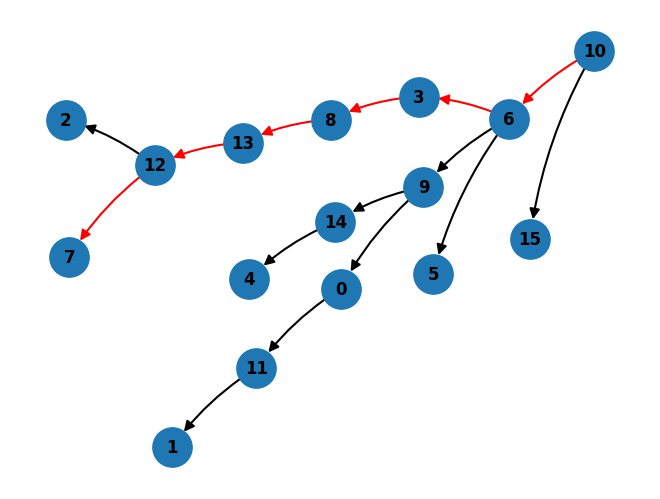

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


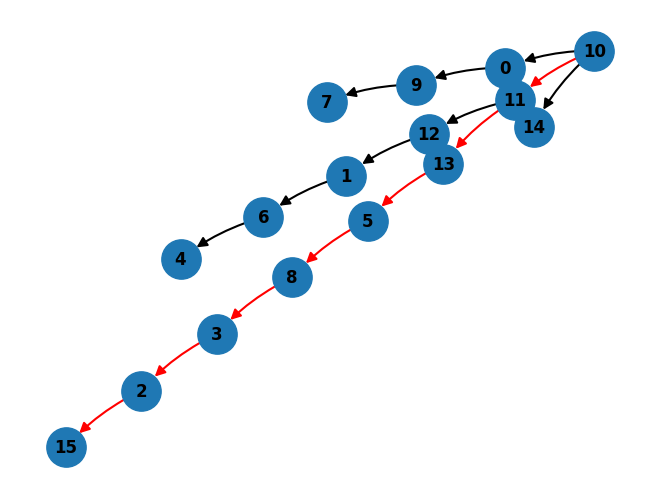

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


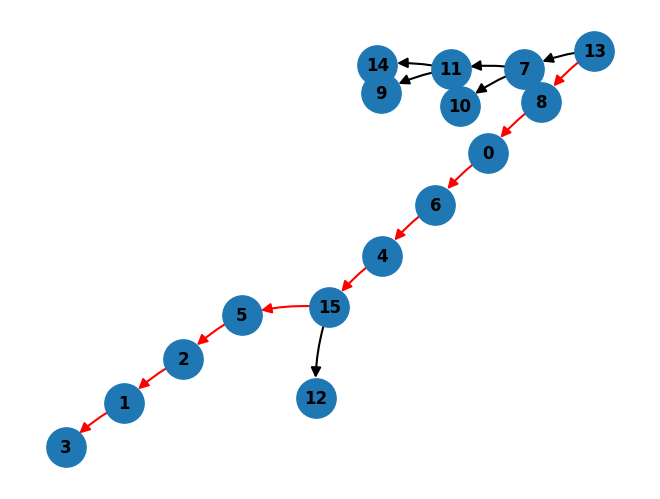

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


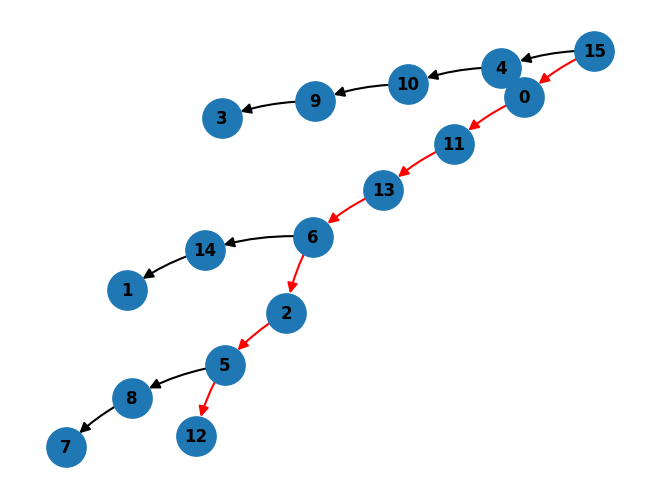

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


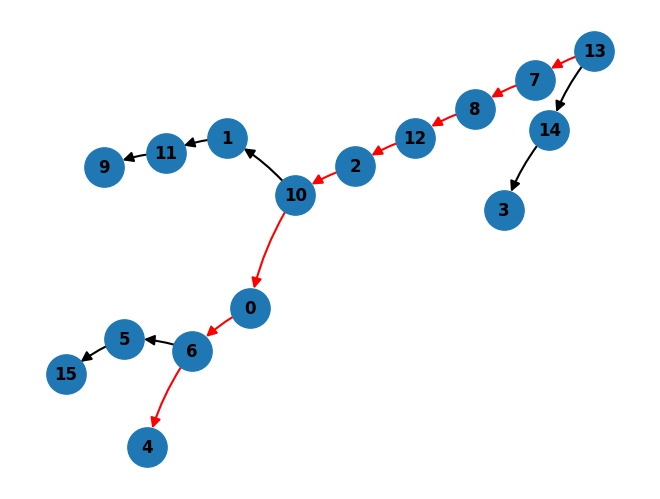

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


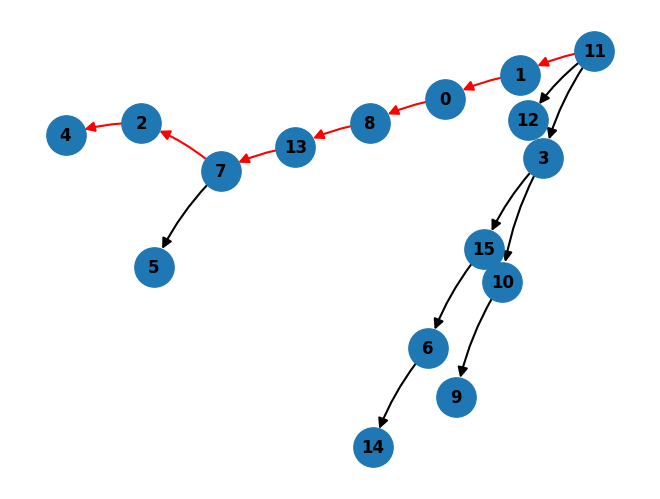

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


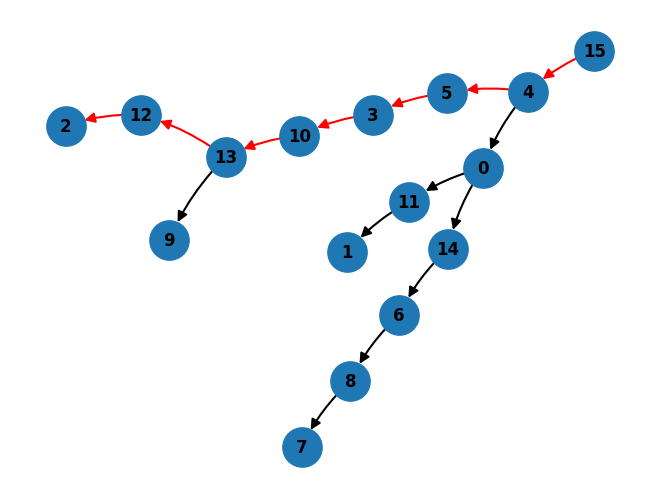

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


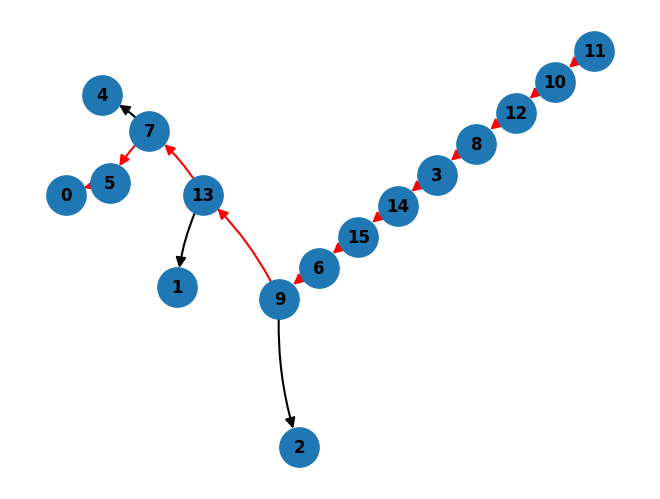

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


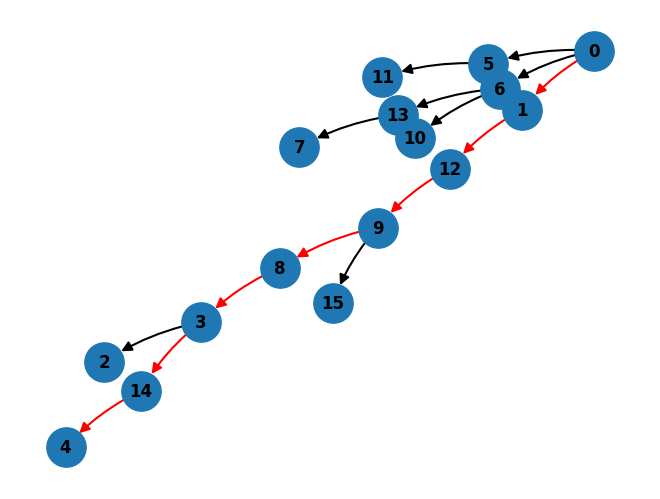

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


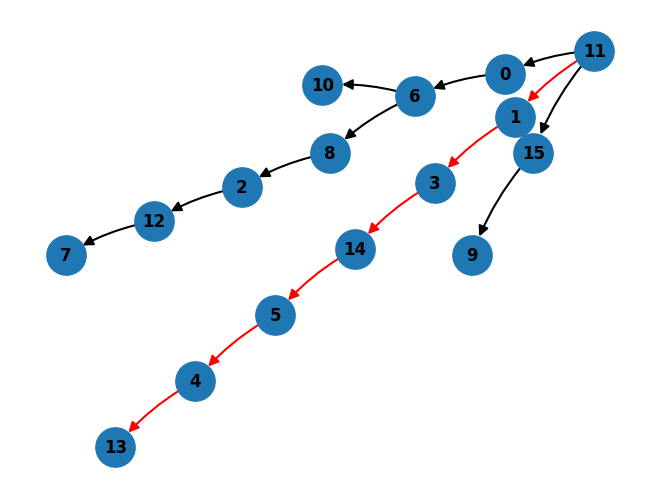

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


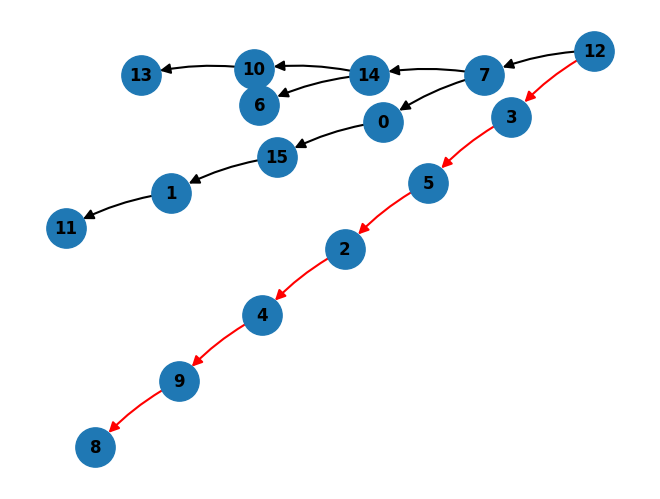

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


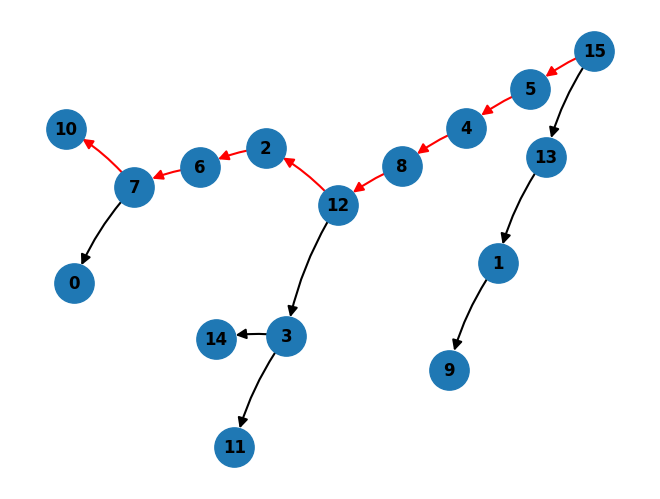

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3
backward: 98.8000%


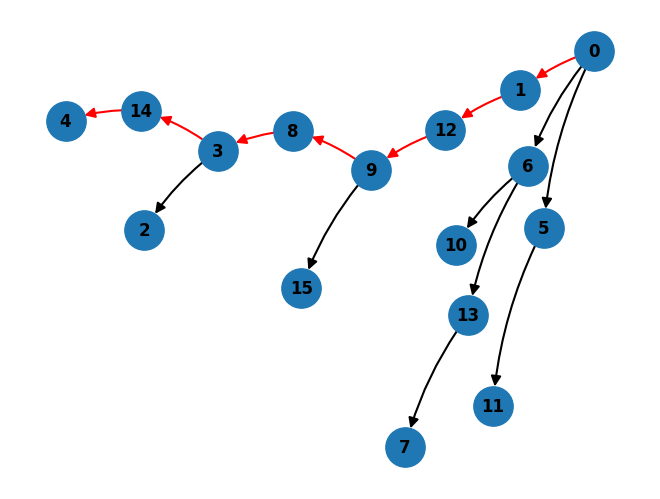

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3
random: 99.9000%


In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1
      else:  
        parse_example(graph)
        plt.show()
        print(pred)      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

forward: 100.0000%


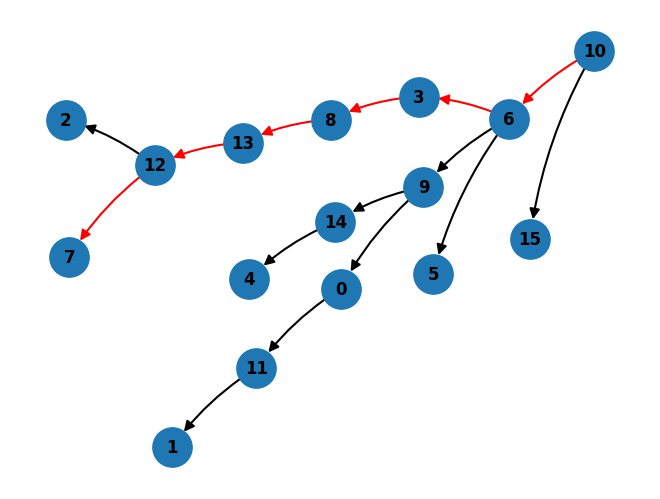

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


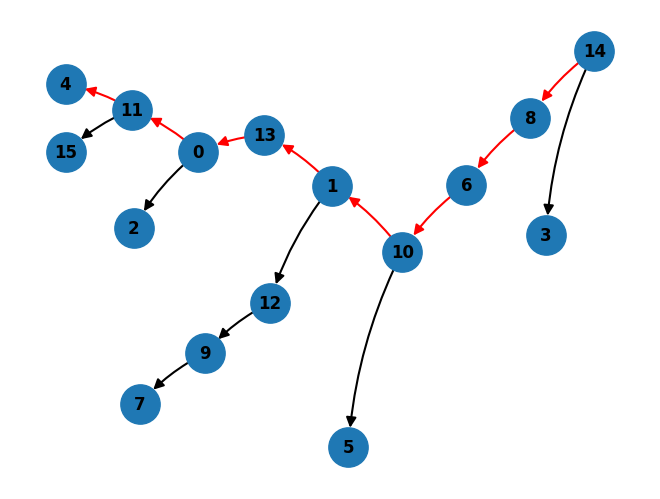

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


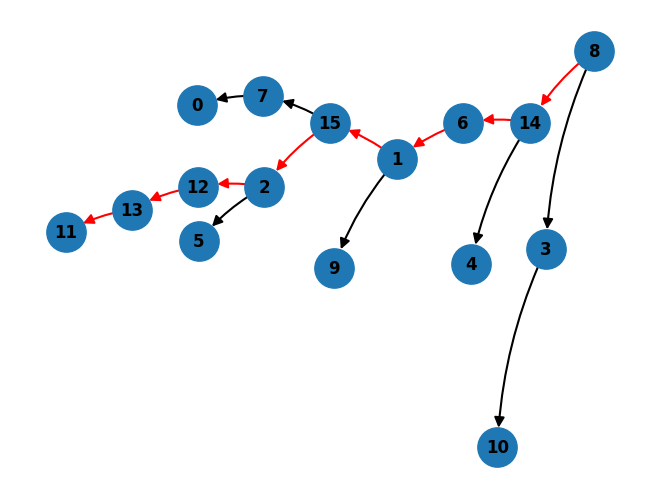

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


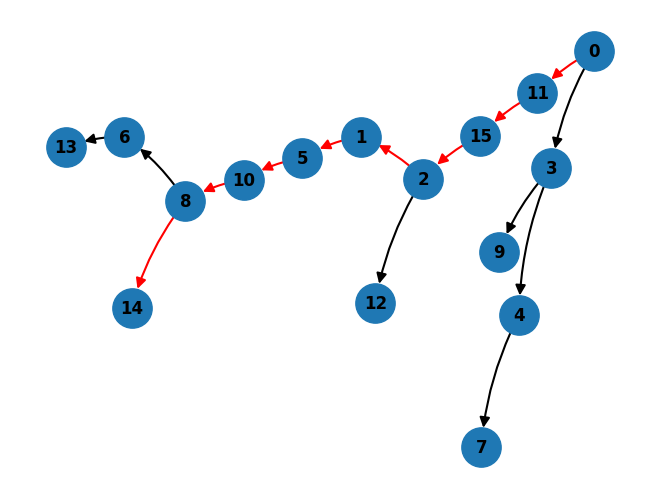

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


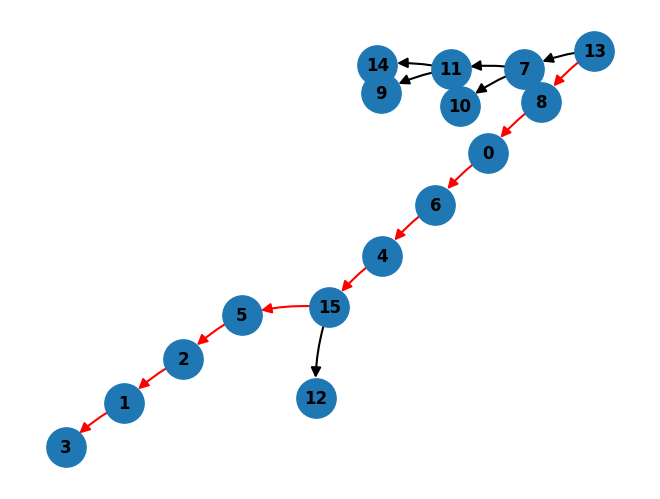

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


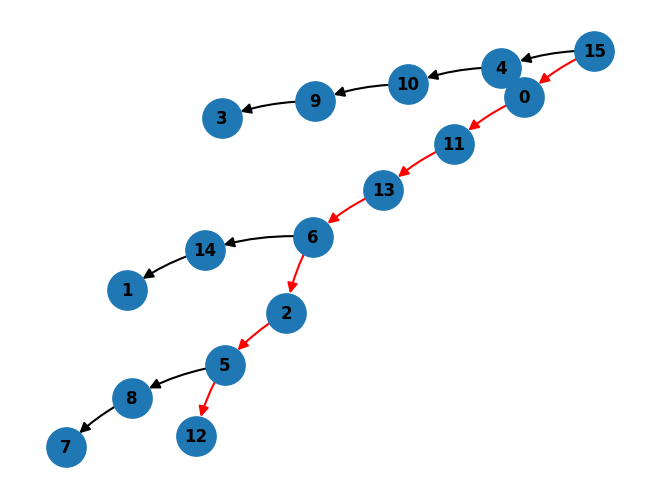

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


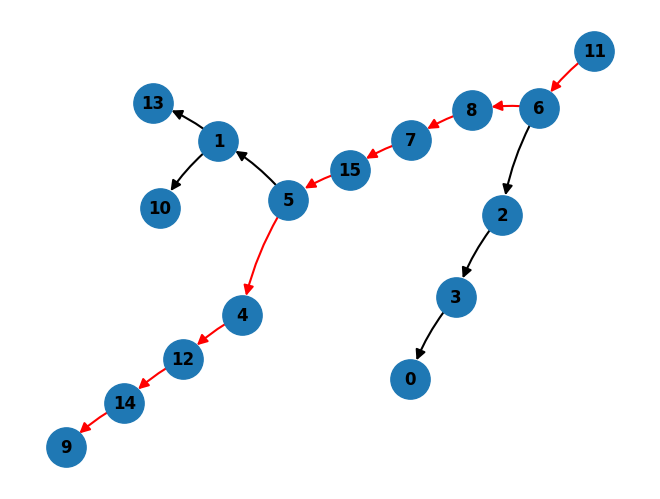

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


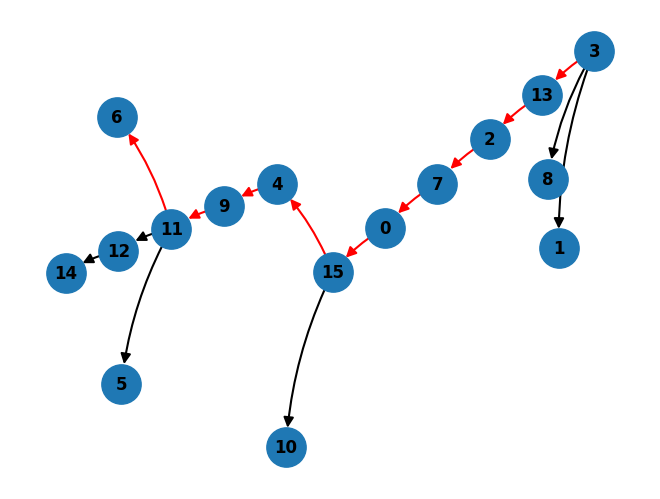

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


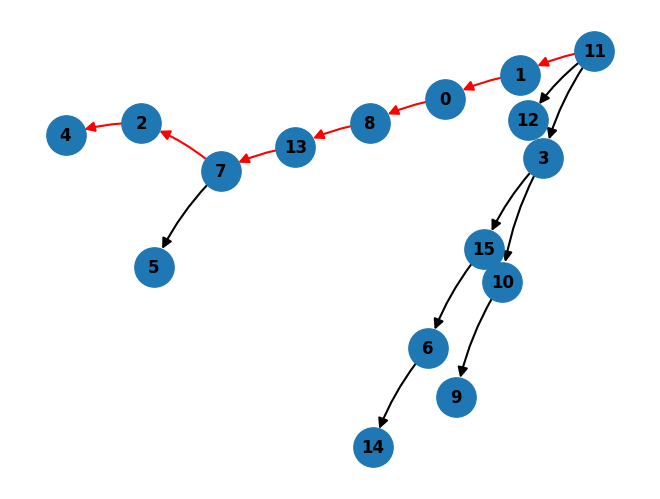

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


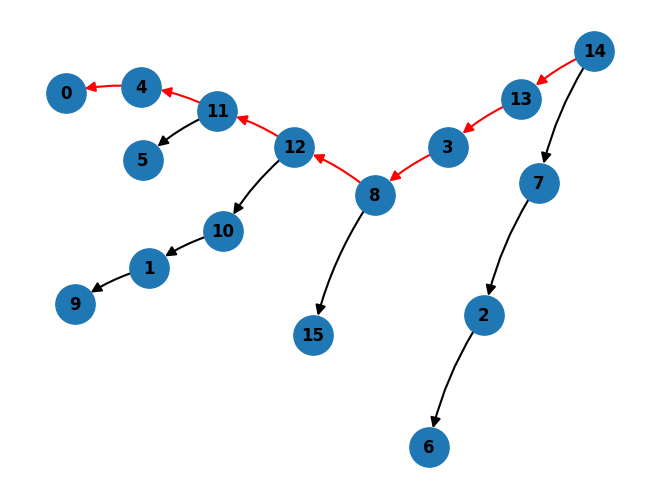

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


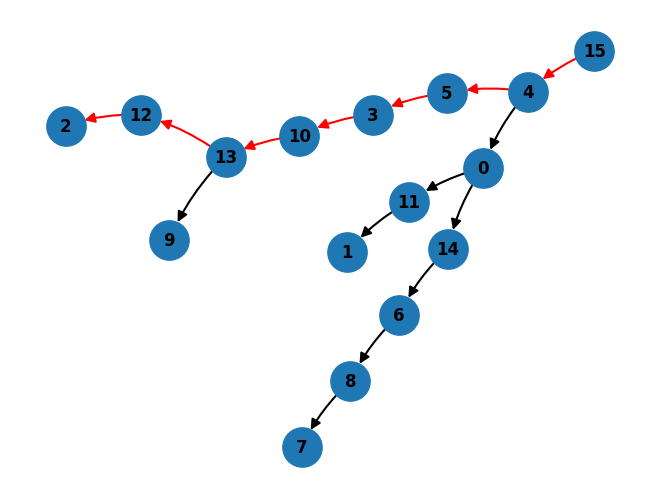

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


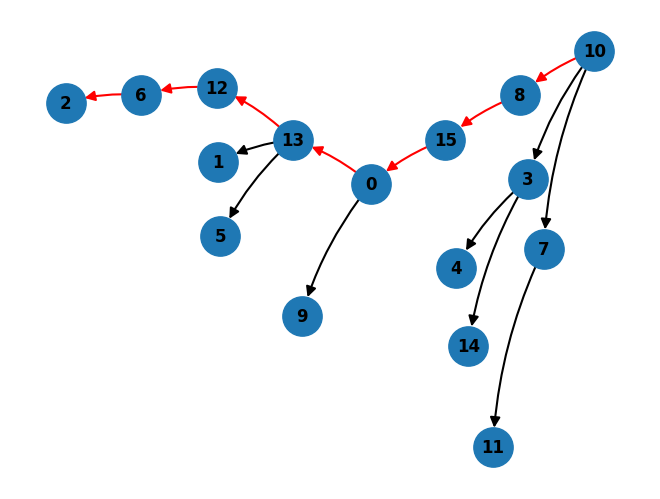

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


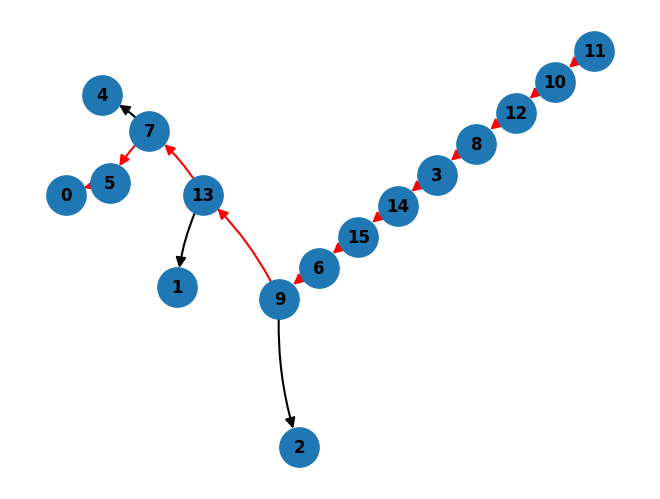

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


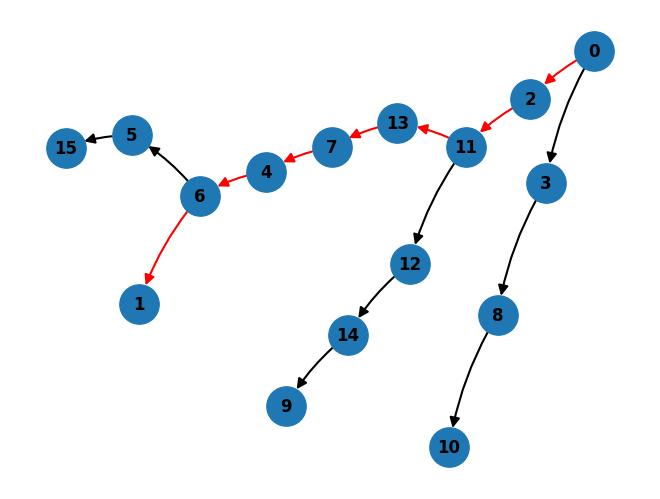

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


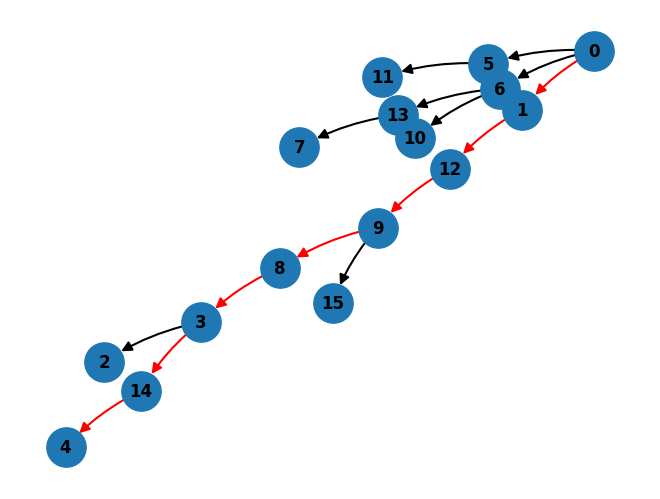

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


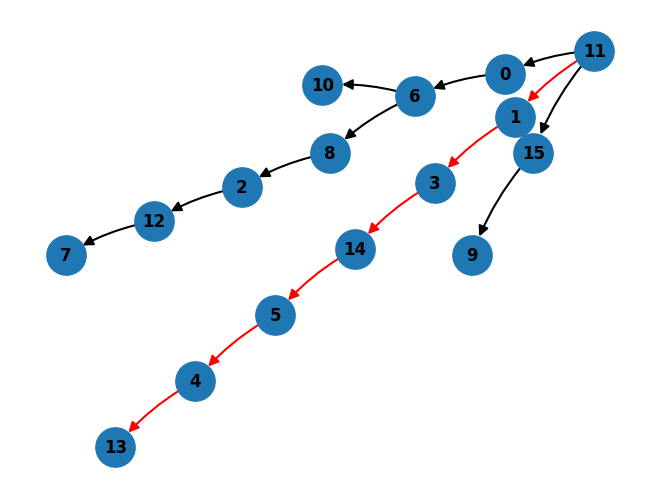

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


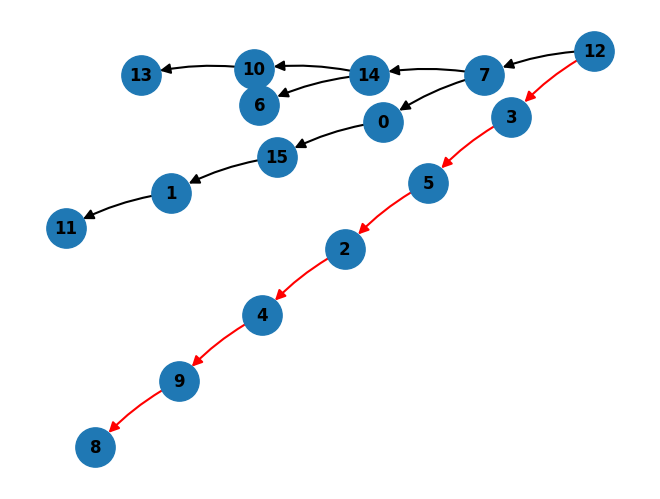

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3


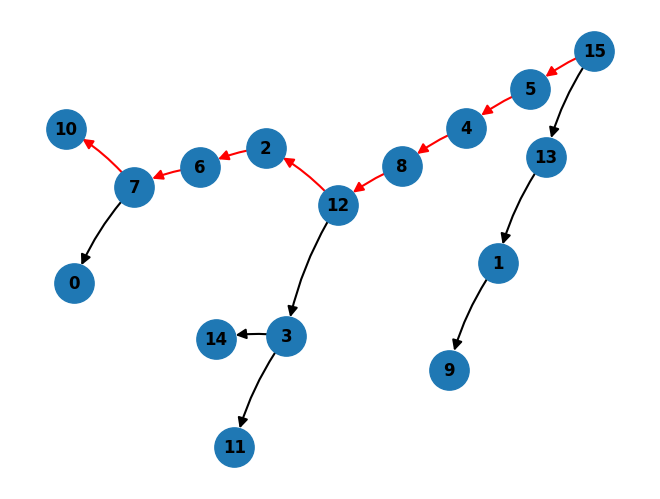

10>9,15>0,2>13,13>8,14>1,9>12,10>14,14>4,6>10,5>11,13>6,4>15,6>5,7>2,0>3|3:7>2>13>6>10>14>4>15>0>3
backward: 98.2000%
random: 100.0000%


In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward","backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1  
      else:  
        parse_example(graph)
        plt.show()
        print(pred)
        
  print(f"{order}: {100* total_correct / num_samples:.4f}%")

In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

In [ ]:
start_seed = 250_000
num_samples = 1_000

for order in ["backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1  
      #else:  
      #  parse_example(graph)
      #  plt.show()
      #  print(pred)
        
  print(f"{order}: {100* total_correct / num_samples:.4f}%")

backward: 94.8000%
random: 96.2000%


In [ ]:
imshow(test_cache["blocks.0.attn.hook_k"][0][:,0,:])

In [ ]:
test_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re